# Отчёт по ДЗ1 ЧМ


## Постановка задачи

Решить начально-краевую задачу для однородного уравнения теплопроводности, которое задаётся следующим образом:
$$
\begin{array}{l}
\dfrac{\partial u}{\partial t} = \alpha \dfrac{\partial^2 u}{\partial x^2} + f(x, t), \; t > 0, \; x \in (0, l_x), \\
\left. u \right|_{t=0} = u_0(x), \\
\left. u \right|_{x=0} = \mu_1(t), \\
\left. u \right|_{x=l_x} = \mu_2(t),
\end{array}$$
где $u(x, t)$ - функция температуры, $\alpha = const$ - коэффициент теплопроводности, $f(x, t)$ - функция источника.

Однако в нашем случае $f(x,t) = 0$, что несколько упрощает задачу

# Уравнение теплопроводности

Начально-краевая задача для уравнения теплопроводности с постоянным коэффициентом в общем виде можно записать следующим образом:
$$
\begin{array}{l}
\dfrac{\partial u}{\partial t} = \alpha \dfrac{\partial^2 u}{\partial x^2} + f(x, t), \; t > 0, \; x \in (0, l_x), \\
\left. u \right|_{t=0} = u_0(x), \\
\left. u \right|_{x=0} = \mu_1(t), \\
\left. u \right|_{x=l_x} = \mu_2(t),
\end{array}$$
где $u(x, t)$ - функция температуры, $\alpha = const$ - коэффициент теплопроводности, $f(x, t)$ - функция источника.

In [1]:
import numpy as np

## Явная схема

Запишем разностное уравнение явной схемы:
$$\dfrac{y_i^{k+1} - y_i^{k}}{\tau} = \alpha \dfrac{y_{i+1}^{k} - 2 y_i^{k} + y_{i-1}^{k}}{h^2} + f_i^k,$$
где $\tau$ и $h$ - шаги по времени и пространству, $y_i^k$ - значение приближённого решения в точке $(i, k)$ сетки, $y_i^k$ - значение функции источника в той же точке сетки.

Откуда выразим $y_i^{k+1}$:
$$y_i^{k+1} = \tau\alpha \dfrac{y_{i+1}^{k} - 2 y_i^{k} + y_{i-1}^{k}}{h^2} + \tau f_i^k + y_i^k$$

Аппроксимируем начальное и граничные условия:
$$
\begin{array}{l}
y_i^0 = u_0(x_i), \; \forall i = \overline{0, N},\\
y_0^k = \mu_1(t_k), \\
y_N^k = \mu_2(t_k), \; \forall k > 0.
\end{array}$$

Запрограммируйте явную разностную схему решения начально-краевой задачи для однородного уравнения теплопроводности. Обратите внимание, что
$$\exists \lim\limits_{t \rightarrow \infty} u(x, t) = u_\infty (x).$$
поэтому расчёт в какой-то момент следует остановить (считать до установления).

Во время проведения расчетов помните о том, что явная схема *условно* устойчива.

In [2]:
def heat_expl(init, bound1, bound2, alpha, lx, h, tau, tol=1e-3):
    """ Solve the heat equation `u_t = a*u_xx` for x in (0; lx) with an explicit scheme.

    Parameters
    ----------
    init : callable
       Initial condition
    bound1 : callable
       Boundary condition for x = 0
    bound1 : callable
       Boundary condition for x = lx
    alpha : float
       Thermal diffusivity
    h : float
       Spatial step
    tau : float
       Time step
    tol : float, optional
       Target tolerance.
       Stop iterations when the 2-norm of the difference between
       solution on this time step and the next is less the tol.

    Returns
    -------
    t_end : float
       End time of calculation
    u_end : ndarray, shape (N,)
       Limit u_∞(x) (See above)
    """
    N = int(lx/h) + 1 # The number of steps
    temp = tau # To count timings

    current_u = np.array([init(h*step) for step in range(N)]) # All initials
    current_u[0], current_u[-1] = bound1(tau), bound2(tau) # Assume initial boundary conditions

    error = 1
    it = 1
    while error > tol: # Breakpoint
        previous_u = current_u.copy() # To count difference later
        current_u[0], current_u[-1] = bound1(temp), bound2(temp) # Pass new boundary conditions
        for i in range(1, N-1):
            current_u[i] = tau*alpha*(previous_u[i+1] - 2*previous_u[i] + previous_u[i-1]) / (h**2) + \
                     + previous_u[i] # Recalculate u using formula

        if it == 100000: # In case it doesn't converge
            raise ValueError('The scheme didn\'t provide conversion')

        temp += tau # Increment time step
        error = np.linalg.norm(current_u - previous_u) # Recalculate the error
        it += 1 # Increment the iteration number

    return temp, current_u

Протестируйте Вашу функцию.

In [3]:
from numpy.testing import assert_allclose

t_0, u_0 = heat_expl(lambda x: 0., lambda x: 1., lambda x: 1.,
                     alpha=1., lx=1., h=0.1, tau=0.005)
assert_allclose(u_0, np.ones(11), atol=1e-2)

t_1, u_1 = heat_expl(lambda x: np.sin(4.*x), lambda x: 0., lambda x: 0.,
                     alpha=1., lx=np.pi, h=0.1, tau=0.005)
assert_allclose(u_1, np.zeros(32), atol=1e-2)


Определите порядки точности схемы (по пространству и времени) на тестовой задаче. Для этого для каждой переменной ($t$ или $x$):

1. Сделайте несколько расчётов для разных значений шага (например, $h_0, \; 2 h_0, \; 4 h_0$).
2. В один и тот же момент времени $t_1$ найдите ошибку полученных решений. Для этого либо возьмите аналитическое решение задачи, либо сравните результат в конечный момент времени, например, с решением в момент времени $0.99 t_1$. Обратите внимание, что имеющуюся функцию `heat_expl` надо немного модифицировать.
3. Найдите отношения этих ошибок. Сопоставьте полученные величины с порядком аппроксимации схемы по данной переменной.

In [4]:
import matplotlib
from matplotlib import pyplot as plt

In [5]:
def modified_heat_expl(init, bound1, bound2, alpha, lx, h, tau, time_stop, true_solution, tol=1e-3):

    N = int(lx/h) + 1 # The number of steps
    temp = tau # To count timings
    length = h # To count spatial distance
    errs = list()

    current_u = np.array([init(h*step) for step in range(N)]) # All initials
    current_u[0], current_u[-1] = bound1(tau), bound2(tau) # Assume initial boundary conditions

    time_error, spatial_error = 0, 0
    error = 1
    while error > tol: # Breakpoint
        previous_u = current_u.copy() # To count difference later
        current_u[0], current_u[-1] = bound1(temp), bound2(temp) # Pass new boundary conditions
        for i in range(1, N-1):
            current_u[i] = tau*alpha*(previous_u[i+1] - 2*previous_u[i] + previous_u[i-1]) / (h**2) + \
                     + previous_u[i] # Recalculate u using formula

#         print(temp)
        time_error = np.linalg.norm(true_solution(length, temp) - current_u)
        errs.append(time_error)
        temp += tau # Increment time step counter
        length += h
        error = np.linalg.norm(current_u - previous_u) # Recalculate the error

    return temp, current_u, time_error

Time error for 𝜏 = 0.005 is 1.192
Time error for 𝜏 = 0.01 is 1.016
Time error for 𝜏 = 0.015 is 0.866
Time error for 𝜏 = 0.02 is 0.738
Time error for 𝜏 = 0.025 is 0.629
Time error for 𝜏 = 0.03 is 0.536
Time error for 𝜏 = 0.035 is 0.457
Time error for 𝜏 = 0.04 is 0.389
Time error for 𝜏 = 0.045 is 0.332
Time error for 𝜏 = 0.05 is 0.282
Time error for 𝜏 = 0.055 is 0.241
Time error for 𝜏 = 0.06 is 0.205
Time error for 𝜏 = 0.065 is 0.175
Time error for 𝜏 = 0.07 is 0.149
Time error for 𝜏 = 0.075 is 0.127
Time error for 𝜏 = 0.08 is 0.108
Time error for 𝜏 = 0.085 is 0.092
Time error for 𝜏 = 0.09 is 0.079
Time error for 𝜏 = 0.095 is 0.067
Time error for 𝜏 = 0.1 is 0.057
Time error for 𝜏 = 0.105 is 0.049
Time error for 𝜏 = 0.11 is 0.041
Time error for 𝜏 = 0.115 is 0.035
Time error for 𝜏 = 0.12 is 0.03
Time error for 𝜏 = 0.125 is 0.026
Time error for 𝜏 = 0.13 is 0.022
Time error for 𝜏 = 0.135 is 0.019
Time error for 𝜏 = 0.14 is 0.016
Time error for 𝜏 = 0.145 is 0.014
Time error for 𝜏 = 0.15 is 0.0

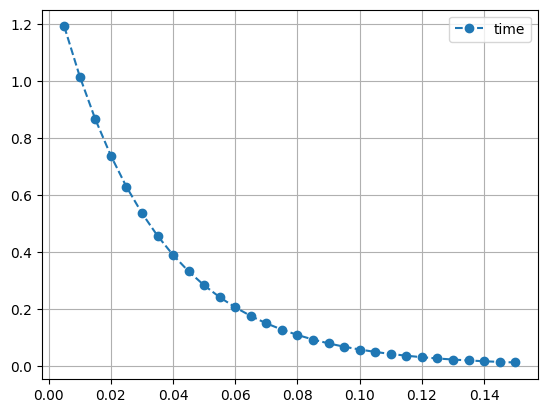

In [16]:
def heat_analytics(x,t): # Taken from Wikipedia
    return np.sin(4*x) * np.exp(-16 * t)

mults = np.array([i for i in range(1,31)])
time_stop = 0.015
time_errors = list()
for i in mults:
    _, _, time_error = modified_heat_expl(lambda x: np.sin(4.*x), lambda x: 0., lambda x: 0.,
                                         alpha=1., lx=np.pi, h=2, tau=0.01*i, time_stop=time_stop, true_solution=heat_analytics)
    time_errors.append(time_error)
    print(f'Time error for 𝜏 = {0.005*i} is {round(time_error,3)}')

plt.grid()
plt.plot(0.005*mults, time_errors, "o--", label='time')
plt.legend()

## Неявная схема

Запишем разностное уравнение неявной схемы:
$$\dfrac{y_i^{k+1} - y_i^{k}}{\tau} = \alpha \dfrac{y_{i+1}^{k+1} - 2 y_i^{k+1} + y_{i-1}^{k+1}}{h^2} + f_i^{k+1}.$$

Аппроксимировать начальное и граничные условия будем так же, как в случае явной схемы.

Запрограммируйте явную разностную схему решения начально-краевой задачи для однородного уравнения теплопроводности. Для решения системы линейных уравнений используйте встроенные функции `scipy`.

Сведём вычисления к матричному виду:
$$\hat{u}_{n-1}\left(\dfrac{D}{h^2}\right) + \left(-2\dfrac{D}{h^2} - \dfrac{1}{\tau}\right)\hat{u}_n + \hat{u}_{n+1}\left(\dfrac{D}{h^2}\right) = f_n$$
или
$$A_n \hat u_{n-1} + B_n \hat u_n + C_n \hat u_{n+1} = F$$
Вычислять u будем следующим образом:
$$u_k = \alpha_{k+1}u_{k+1} + \beta_{k+1}$$
$$u_{n-1} = \alpha_n u_n + \beta_n$$
$$u_n = \alpha_{n-1} u_{n-1} + \beta_{n-1}$$

In [8]:
def heat_impl(init, bound1, bound2, alpha, lx, h, tau, tol=1e-3):
    """ Solve heat equation u_t = a*u_xx for x in (0; lx) with implicit scheme

    Parameters
    ----------
    init : callable
       Initial condition
    bound1 : callable
       Boundary condition for x = 0
    bound1 : callable
       Boundary condition for x = lx
    alpha : float, optional
       Thermal diffusivity
    h : float
       Spatial step
    tau : float
       Time step
    tol : float, optional
       Target tolerance.
       Stop iterations when the 2-norm of the difference between
       solution on this time step and the next is less the tol.

    Returns
    -------
    t_end : float
       End time of calculation
    u_end : ndarray, shape (N,)
       Limit u_∞(x) (See above)
    """
    N = int(lx/h) + 1
    temp = tau

    A = alpha/h**2 # C = A, so I didn't create another variable
    B = -2*A - 1/tau

    alpha, beta = np.zeros(N), np.zeros(N)

    M = np.eye(N, N) # A matrix of a system of equations to solve in implicit scheme
    b = np.zeros(N)

    current_u = [init(x) for x in range(N)] # At the beginning it's all initials
    previous_u = np.zeros(N) # To count difference later

    error = 1
    while error > tol:
        beta[1] = bound1(temp)
        for i in range(2, N): # Calculate alpha and beta at this step
            alpha[i] = -A / (A*alpha[i-1] + B)
            beta[i] = -(A*beta[i-1] + current_u[i-1]/tau) / (A*alpha[i-1] + B)

        for i in range(1, N-2): # I need to fill pre last one
            M[i][i+1] = -alpha[i+1]
            b[i] = beta[i+1]

        b[0] = beta[1] # Reset all initials
        b[-1] = bound2(temp)
        b[-2] = alpha[-1]*b[-1] + beta[-1]

        current_u = np.linalg.solve(M,b)
        error = np.linalg.norm(current_u - previous_u) # Recalculate error
        previous_u = current_u.copy() # Save current
        temp += tau # Increment timings

    return temp, current_u

Протестируйте Вашу функцию.

In [9]:
from numpy.testing import assert_allclose

t_0, u_0 = heat_impl(lambda x: 0., lambda x: 1., lambda x: 1.,
                     alpha=1., lx=1., h=0.1, tau=0.005)
assert_allclose(u_0, np.ones(11), atol=1e-2)

t_1, u_1 = heat_impl(lambda x: np.sin(4.*x), lambda x: 0., lambda x: 0.,
                     alpha=1., lx=np.pi, h=0.1, tau=0.005)
assert_allclose(u_1, np.zeros(32), atol=1e-2)


Определите порядки точности схемы (по пространству и времени) на тестовой задаче. (см. выше)

In [10]:
def modified_heat_impl(init, bound1, bound2, alpha, lx, h, tau, time_stop, spatial_stop, true_solution, tol=1e-3):
    N = int(lx/h) + 1
    temp = tau
    length = h

    A = alpha/h**2 # C = A, so I didn't create another variable
    B = -2*A - 1/tau

    alpha, beta = np.zeros(N), np.zeros(N)

    M = np.eye(N, N)
    b = np.zeros(N)

    current_u = [init(x) for x in range(N)]
    previous_u = np.zeros(N)

    error = 1
    time_error, spatial_error = 0, 0
    while error > tol:
        beta[1] = bound1(temp)
        for i in range(2, N):
            alpha[i] = -A / (A*alpha[i-1] + B)
            beta[i] = -(A*beta[i-1] + current_u[i-1]/tau) / (A*alpha[i-1] + B)

        for i in range(1, N-2):
            M[i][i+1] = -alpha[i+1]
            b[i] = beta[i+1]

        b[0] = beta[1]
        b[-1] = bound2(temp)
        b[-2] = alpha[-1]*b[-1] + beta[-1]

        current_u = np.linalg.solve(M,b)
        error = np.linalg.norm(current_u - previous_u)
        if round(temp, 3) == time_stop:
            time_error = np.linalg.norm(current_u - true_solution)
        if round(length, 2) == spatial_stop:
            spatial_error = np.linalg.norm(current_u - true_solution)
        previous_u = current_u.copy()
        temp += tau
        length += h

    return temp, current_u, time_error, spatial_error

Time error for h=0.1 is 0.017663564793566202
Spatial error for h=0.1 is 0.017663564793566202

Time error for h=0.2 is 0.016647667157166604
Spatial error for h=0.2 is 0.08936855360818576

Time error for h=0.4 is 0.2783473508651399
Spatial error for h=0.4 is 1.1682313858946936

Отношения временных ошибок: 0.942486262072669, 16.719901247263643, 15.758277228757667
Отношения пространственных ошибок: 5.05948570702656, 13.072063256349814, 66.13791720684895


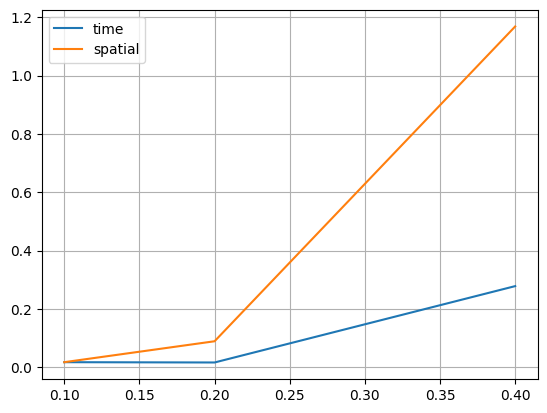

In [11]:
time_errors, spatial_errors = list(), list()
t = 0.1
l = 2
for i,j in enumerate([1, 2, 4]):
    true_solution = np.zeros(32//j)
    _, _, time_error, spatial_error = modified_heat_impl(lambda x: np.sin(4.*x), lambda x: 0., lambda x: 0.,
                                                         alpha=1., lx=np.pi, h=0.1*j, tau=0.005, time_stop=t,
                                                         spatial_stop=l, true_solution=true_solution)
    time_errors.append(time_error)
    spatial_errors.append(spatial_error)
    print(f'Time error for h={0.1*j} is {time_errors[i]}')
    print(f'Spatial error for h={0.1*j} is {spatial_errors[i]}\n')

print(f'Отношения временных ошибок: {time_errors[1]/time_errors[0]},' \
      f' {time_errors[2]/time_errors[1]}, {time_errors[2]/time_errors[0]}')
print(f'Отношения пространственных ошибок: {spatial_errors[1]/spatial_errors[0]},' \
      f' {spatial_errors[2]/spatial_errors[1]}, {spatial_errors[2]/spatial_errors[0]}')

plt.grid()
plt.plot([0.1*j for j in [1,2,4]], time_errors, label='time')
plt.plot([0.1*j for j in [1,2,4]], spatial_errors, label='spatial')
plt.legend()